In [190]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression

from useful_functions.plotter import plot

idx = pd.IndexSlice

In [225]:
populations = pd.read_csv('../data/US_States/TrackTheRecovery/GeoIDs - State.csv', index_col='statefips')
case_data = pd.read_csv('../DL/data/states_unstacked_full.csv')
case_data = case_data[case_data['date'] <= '2021-02-25']
case_data = case_data[case_data['date'] >= '2020-03-07']

# Trying to reproduce results

#case_data = case_data[case_data['date'] <= '2020-06-08']
#case_data = case_data[case_data['date'] >= '2020-03-14']

#case_data = case_data.rename(columns={'Unnamed: 0': "statefips"})
case_data = case_data.sort_values(['date','statefips'])
case_data = case_data.reset_index(drop=True).set_index(['statefips','date']) # Let's see how this works
iso_index = pd.read_csv('../data/US_States/cleaned_data/mobility_pca_only.csv')
iso_index = iso_index.sort_values(['Date', 'statefips'])

case_data.index = case_data.index.set_levels([case_data.index.levels[0], pd.to_datetime(case_data.index.levels[1])])

state_ids = populations.index.values
dates = iso_index['Date'].unique()
dates.sort()

In [226]:
# Computing the corrective factor at the national level
case_data_weekly = case_data.groupby([pd.Grouper(freq='W', level='date')]).sum()

case_data_weekly['deathIncreaseIn1Week'] = case_data_weekly['deathIncrease'].shift(-1)
case_data_weekly['positiveFraction'] = case_data_weekly['positiveIncrease'] / case_data_weekly['totalTestResultsIncrease']
# totalTestEncountersViralIncrease vs. totalTestsPeopleViralIncrease
# ended up having to use totalTestsResultsIncrease, because it is the only one reported for every state...

case_data_weekly['positiveIncreaseTimesPositiveFraction'] = case_data_weekly['positiveFraction']*case_data_weekly['positiveIncrease']


case_data_weekly = case_data_weekly.loc[:,['positiveIncrease', 'deathIncrease', 'deathIncreaseIn1Week', 'positiveFraction', 'positiveIncreaseTimesPositiveFraction']]

case_data_weekly = case_data_weekly.iloc[1:-2,:]

In [227]:
case_data_weekly

,positiveIncrease,deathIncrease,deathIncreaseIn1Week,positiveFraction,positiveIncreaseTimesPositiveFraction
date,,,,,
2020-03-15,4924,48,399.0,0.102952,506.936857
2020-03-22,33975,399,2353.0,0.121726,4135.647684
2020-03-29,110858,2353,7761.0,0.176038,19515.190656
2020-04-05,190902,7761,13238.0,0.198844,37959.801974
2020-04-12,217325,13238,14480.0,0.199960,43456.241765
2020-04-19,198739,14480,12988.0,0.180583,35888.885667
2020-04-26,210719,12988,12775.0,0.132733,27969.424940
2020-05-03,191541,12775,12445.0,0.110312,21129.317991
2020-05-10,170599,12445,9617.0,0.083263,14204.614252


In [219]:
# Regress weekly cases * (1+alpha*p) against one-week-future weekly deaths
# no intercept

X = case_data_weekly.loc[:, 'positiveIncrease'].values.reshape(-1, 1)
Y = case_data_weekly.loc[:, 'deathIncreaseIn1Week'].values.reshape(-1, 1)
linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
print(linear_regressor.score(X,Y), linear_regressor.coef_)

case_data_weekly['baseline_estimate'] = Y_pred

0.4156957612580471 [[0.01457029]]


<AxesSubplot:xlabel='date'>

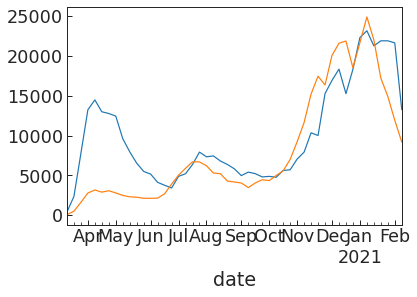

In [220]:
case_data_weekly['deathIncreaseIn1Week'].plot()
case_data_weekly['baseline_estimate'].plot()

In [221]:
# I want to do this myself to make sure it's being done correctly

from scipy.optimize import curve_fit

def func(x, p1, p2):
    return p1*x[:,0]*(1. + p2*x[:,1])

x = case_data_weekly.loc[:, ['positiveIncrease','positiveFraction']].values
y = case_data_weekly.loc[:, 'deathIncreaseIn1Week'].values

curve_fit(func, x, y, p0=[1.,1.])

# Unfortunately, this also gives the same issue as the simple approach below, so I'm really not sure what they're doing in the
# paper, but I'm not able to reproduce their corrective factor

# Regardless, if I WAS able to reproduce their corrective factor, we should note that it only amounts to a <2% effect,
# so it REALLY isn't worth worrying about!

# https://www.medrxiv.org/content/medrxiv/early/2020/06/28/2020.06.26.20141135.full.pdf paper for reference

(array([ 0.01618054, -0.97093259]),
 array([[ 1.74498532e-05, -8.95594153e-03],
        [-8.95594153e-03,  4.89385110e+00]]))

In [222]:
X = case_data_weekly.loc[:, ['positiveIncrease','positiveIncreaseTimesPositiveFraction']].values.reshape(-1, 2)
Y = case_data_weekly.loc[:, 'deathIncreaseIn1Week'].values.reshape(-1, 1)
linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
print(linear_regressor.score(X,Y), linear_regressor.coef_)

case_data_weekly['enhanced_estimate'] = Y_pred

0.41763241324367517 [[ 0.01618054 -0.01571022]]


<AxesSubplot:xlabel='date'>

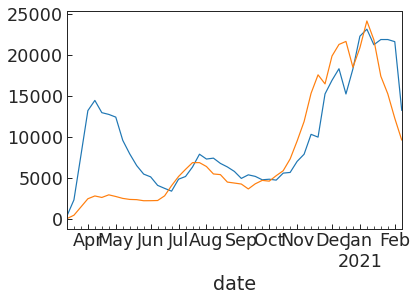

In [223]:
case_data_weekly['deathIncreaseIn1Week'].plot()
case_data_weekly['enhanced_estimate'].plot()

# This correction barely improves things at all when taken over the entire dataset.